In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['MKL_DEBUG_CPU_TYPE'] = '5' # 强制 MKL 使用兼容模式
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
from src.data_loader import GasSensorLoader
from src.models import GasSensorMLP
# 1. 初始化加载器
loader = GasSensorLoader(data_dir='../Dataset') # 确保路径正确

# 2. 加载 Batch 1 (Week 1 定义的训练基准)
X_raw, y_raw = loader.load_batch(1)

# 3. 按协议 Reshape (N, 128) -> (N, 16, 8)
X_reshaped = X_raw.reshape(-1, 16, 8)
print(f"Loaded Shape: {X_raw.shape} -> Reshaped: {X_reshaped.shape}")

# 4. 核心预处理：对数转换与全局标准化
# 提前计算 Log，避免在 Augmentor 中重复计算
X_log = np.log1p(np.abs(X_reshaped)) * np.sign(X_reshaped)

# 推荐：全局 Z-Score 标准化（使数据均值 0，方差 1）
X_mean = X_log.mean()
X_std = X_log.std()
X_normalized = (X_log - X_mean) / (X_std + 1e-8)

print(f"预处理完成！数据范围: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")

Loaded Shape: (445, 128) -> Reshaped: (445, 16, 8)
预处理完成！数据范围: [-2.26, 3.32]


In [3]:
from torch.utils.data import Dataset, DataLoader
from src.augmentations import GasAugmentor

class GasContrastiveDataset(Dataset):
    def __init__(self, data, augmentor):
        self.data = data.astype(np.float32)
        self.augmentor = augmentor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        # 调用 augmentor.__call__ 返回 (view1, view2) Tensor 对
        v1, v2 = self.augmentor(sample) 
        return v1, v2

In [5]:
# 初始化你刚刚在 src/augmentations.py 写好的增强器
# 注意：现在的 augmentor 不再负责 Log，只负责扰动
aug = GasAugmentor(sigma_jitter=0.03, sigma_scaling=0.1)

# 创建 Dataset 和 DataLoader
dataset = GasContrastiveDataset(X_normalized, aug)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# 验证输出
v1, v2 = next(iter(train_loader))
print(f"Batch View1 Shape: {v1.shape}") # 应为 (128, 16, 8)
print(f"Batch View2 Shape: {v2.shape}") # 应为 (128, 16, 8)

Batch View1 Shape: torch.Size([128, 16, 8])
Batch View2 Shape: torch.Size([128, 16, 8])


16 个传感器（空间维度）：这代表了你硬件阵列中所有的“鼻子细胞”。8 个特征（时间/逻辑维度）：这代表了每一个“鼻子细胞”在接触气体时，从响应起始到稳态、再到恢复的 8 个关键抓拍点。1 个样本 ($16 \times 8$)：这 128 个数值共同构成了一张**“气体瞬态指纹图”**。

# 目标是让模型学到一个函数 $f(\cdot)$，使得 $f(View1)$ 和 $f(View2)$ 在数学空间里靠得足够近。

In [9]:
import torch
import torch.nn as nn

class GasResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        # 第一层卷积：提取传感器通道间的局部关联
        self.conv1 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        # 残差块：捕捉深层协同特征
        self.res_block = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32)
        )
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, embedding_dim)

    def forward(self, x):
        x = self.conv1(x)
        residual = x
        x = self.relu(self.res_block(x) + residual)
        h = self.pool(x).squeeze(-1)
        return self.fc(h) # 输出 32 维特征 h

class SimCLRWrapper(nn.Module):
    def __init__(self, encoder, projection_dim=64):
        super().__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h) # 输出 64 维投影 z 用于计算 Loss
        return z

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        self.epsilon = 1e-8

    def forward(self, z_i, z_j):
        """
        z_i, z_j: (Batch, Projection_Dim)
        """
        batch_size = z_i.shape[0]
        # 1. 拼接两个视图得到 2N 个特征向量
        features = torch.cat([z_i, z_j], dim=0) # (256, 64)
        
        # 2. L2 归一化：将向量投影到单位球面上，以便计算余弦相似度
        features = F.normalize(features, p=2, dim=1)
        
        # 3. 计算 2N x 2N 的相似度矩阵 (特征与其转置相乘)
        similarity_matrix = torch.matmul(features, features.T) # (256, 256)
        
        # 4. 生成 Mask 剔除“自己和自己”的相似度 (对角线)
        mask = torch.eye(2 * batch_size, device=z_i.device).bool()
        # 提取除了对角线以外的所有项，reshape 回 (2N, 2N-1)
        logits = similarity_matrix[~mask].view(2 * batch_size, -1)
        
        # 5. 将相似度缩放（除以温度系数 tau）
        logits = logits / self.temperature
        
        # 6. 构建目标：对于每一行，正样本都在固定的位置
        # 在 [z_i, z_j] 拼接模式下，样本 i 的分身在 i + batch_size
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),
            torch.arange(0, batch_size)
        ], dim=0).to(z_i.device)
        
        # 由于我们之前去掉了对角线，labels 需要根据偏移进行调整
        # 这里简化处理：直接找原始 index 对应的正样本位置
        target_labels = torch.arange(batch_size, device=z_i.device)
        target_labels = torch.cat([target_labels + batch_size - 1, target_labels], dim=0)
        # 实际上 labels = 样本 i 的对应正样本在 logits 中的索引
        # 对于 i < N, 正样本在 i + N - 1；对于 i >= N, 正样本在 i - N

        loss = F.cross_entropy(logits, labels - (labels >= (torch.arange(2*batch_size).to(z_i.device))).long())
        
        # 7. 计算监控指标：正样本平均相似度和负样本平均相似度
        pos_sim = torch.diag(similarity_matrix, batch_size).mean()
        neg_sim = logits.mean()
        
        return loss, pos_sim, neg_sim

In [13]:
# 1. 模拟数据
batch_size = 128
projection_dim = 64
z_i = torch.randn(batch_size, projection_dim)
z_j = z_i + torch.randn(batch_size, projection_dim) * 0.1 # 模拟一个很接近的正样本

# 2. 实例化 Loss
criterion = NTXentLoss(temperature=0.1)

# 3. 计算
loss, pos_sim, neg_sim = criterion(z_i, z_j)

print(f"--- Loss Check ---")
print(f"Initial Loss: {loss.item():.4f}")
print(f"Positive Similarity: {pos_sim.item():.4f}") # 应该接近 1.0
print(f"Negative Similarity: {neg_sim.item():.4f}") # 应该接近 0.0 或更低

--- Loss Check ---
Initial Loss: 0.0257
Positive Similarity: 0.9950
Negative Similarity: 0.0470


In [21]:
import torch.optim as optim
from tqdm import tqdm

# 1. 初始化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = GasResNetEncoder(embedding_dim=32)
model = SimCLRWrapper(encoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = NTXentLoss(temperature=0.1)

# 2. 训练配置
epochs = 50 # TinyML 任务通常收敛很快
history = {'loss': [], 'pos_sim': [], 'neg_sim': []}

# 3. 训练循环
for epoch in range(epochs):
    model.train()
    total_loss, total_pos, total_neg = 0, 0, 0
    
    # 使用 tqdm 显示进度条
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for v1, v2 in pbar:
        v1, v2 = v1.to(device).float(), v2.to(device).float()
        
        # Forward
        z_i = model(v1)
        z_j = model(v2)
        
        loss, psim, nsim = criterion(z_i, z_j)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 累计指标
        total_loss += loss.item()
        total_pos += psim.item()
        total_neg += nsim.item()
        
        pbar.set_postfix({'loss': f"{loss.item():.4f}", 'pos': f"{psim.item():.3f}"})
    
    # 记录历史
    n_batches = len(train_loader)
    history['loss'].append(total_loss / n_batches)
    history['pos_sim'].append(total_pos / n_batches)
    history['neg_sim'].append(total_neg / n_batches)

Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.30it/s, loss=1.1257, pos=0.945]


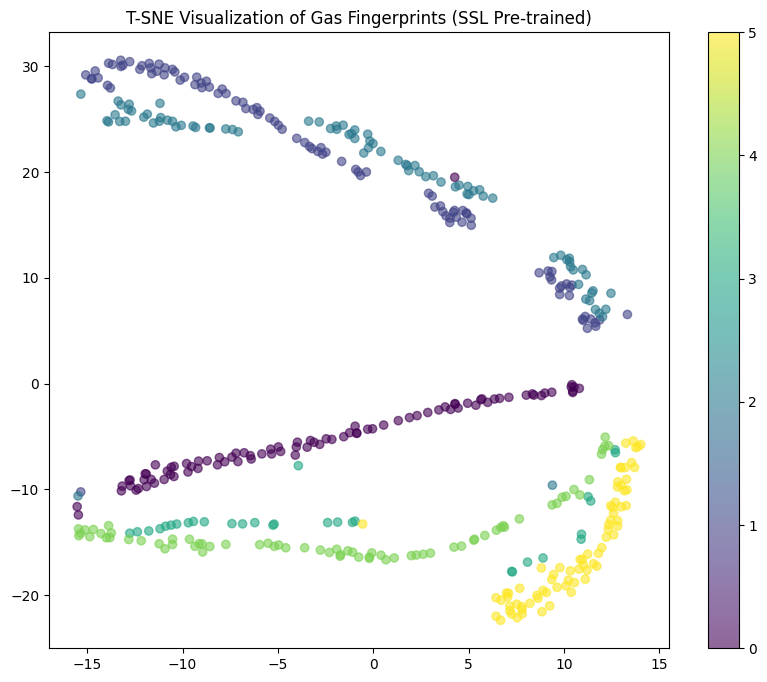

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. 提取所有数据的特征 (使用训练好的 encoder)
model.eval()
all_embeddings = []
with torch.no_grad():
    # 注意：这里直接用 X_normalized，不需要增强
    X_tensor = torch.from_numpy(X_normalized).float().to(device)
    # 只取 encoder 的输出 (32维)，不要 projection head
    embeddings = encoder(X_tensor) 
    all_embeddings = embeddings.cpu().numpy()

# 2. T-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# 3. 可视化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_raw, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title("T-SNE Visualization of Gas Fingerprints (SSL Pre-trained)")
plt.show()

In [27]:
from torchsummary import summary

# 实例化你的 Encoder (这是我们要部署的核心)
# 假设你设定的 embedding_dim 是 32
test_encoder = GasResNetEncoder(embedding_dim=32).to(device)

# 打印审计报告
# 这里的 (16, 8) 必须与你的输入协议一致
summary(test_encoder, input_size=(16, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 32, 8]           1,568
       BatchNorm1d-2                [-1, 32, 8]              64
              ReLU-3                [-1, 32, 8]               0
            Conv1d-4                [-1, 32, 8]           3,104
       BatchNorm1d-5                [-1, 32, 8]              64
              ReLU-6                [-1, 32, 8]               0
            Conv1d-7                [-1, 32, 8]           3,104
       BatchNorm1d-8                [-1, 32, 8]              64
              ReLU-9                [-1, 32, 8]               0
AdaptiveAvgPool1d-10                [-1, 32, 1]               0
           Linear-11                   [-1, 32]           1,056
Total params: 9,024
Trainable params: 9,024
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

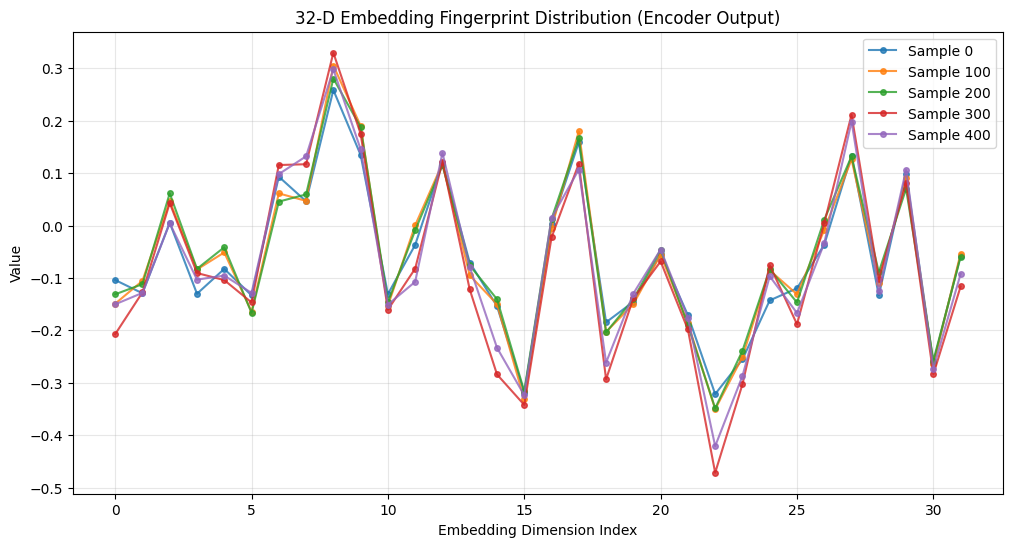

Embedding Variance: 0.0241
Embedding Max: 0.3298, Min: -0.4716


In [29]:
import matplotlib.pyplot as plt

# 1. 切换到评价模式
test_encoder.eval()

# 2. 随机取几个样本 (比如 5 个不同类别的样本)
# 假设你已经准备好了 X_normalized (N, 16, 8)
sample_indices = [0, 100, 200, 300, 400] 
samples = torch.from_numpy(X_normalized[sample_indices]).float().to(device)

with torch.no_grad():
    # 得到 32 维 Embedding
    embeddings = test_encoder(samples).cpu().numpy()

# 3. 可视化分布
plt.figure(figsize=(12, 6))
for i in range(len(sample_indices)):
    plt.plot(embeddings[i], label=f'Sample {sample_indices[i]}', alpha=0.8, marker='o', markersize=4)

plt.title("32-D Embedding Fingerprint Distribution (Encoder Output)")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. 统计检查：计算标准差
print(f"Embedding Variance: {embeddings.var():.4f}")
print(f"Embedding Max: {embeddings.max():.4f}, Min: {embeddings.min():.4f}")